# 実践コンピュータビジョン
# 7章 画像検索
## 7.5 配置を用いて結果をランキングする
テキストp.166

In [12]:
import pickle
%matplotlib inline

In [2]:
import sift
import imagesearch
import homography

In [3]:
# 画像リストを読み込む
with open('ukbench_imlist.pkl','rb') as f:
    imlist = pickle.load(f)
    featlist = pickle.load(f)

nbr_images = len(imlist)
nbr_images

1000

In [4]:
# ボキャブラリを読み込む
with open('vocabulary.pkl', 'rb') as f:
    voc = pickle.load(f)

In [5]:
# Searcherインスタンスを作成する
src = imagesearch.Searcher('test.db',voc)

In [6]:
# クエリ画像の番号と、検索結果の個数
q_ind = 100
nbr_results = 20

# 通常の検索
res_reg = [w[1] for w in src.query(imlist[q_ind])[:nbr_results]]
print('top matches (regular):', res_reg)

top matches (regular): [101, 103, 102, 104, 880, 879, 878, 320, 23, 22, 328, 574, 877, 73, 439, 766, 344, 295, 75, 235]


In [7]:
# クエリ画像の特徴量を読み込む
q_locs, q_descr = sift.read_features_from_file(featlist[q_ind])
q_locs[:,[0,1]] = q_locs[:,[1,0]]
fp = homography.make_homog(q_locs[:,:2].T)

In [8]:
# ホモグラフィーの対応付け用のRANSACモデル
model = homography.RansacModel()
rank = {}

In [9]:
# 検索結果の画像特徴量を読み込む
for ndx in res_reg[1:]:
    locs,descr = sift.read_features_from_file(featlist[ndx-1])
    locs[:,[0,1]] = locs[:,[1,0]]

    # 一致度を調べる
    matches = sift.match(q_descr,descr)
    ind = matches.nonzero()[0]
    ind2 = matches[ind]
    tp = homography.make_homog(locs[:,:2].T)

    # ホモグラフィーを計算し、インライアを数える。
    # 一致度が足りなければ空リストを返す。
    try:
        H,inliers = homography.H_from_ransac(fp[:,ind],tp[:,ind2],
                                         model, match_theshold=4)
    except:
        inliers = []

    # インライアの数を格納する
    rank[ndx] = len(inliers)

In [10]:
# 最もモデルに当てはまるものが先頭になるよう辞書をソートする
sorted_rank = sorted(rank.items(), key=lambda t: t[1], reverse=True)
res_geom = [res_reg[0]]+[s[0] for s in sorted_rank]
print('top matches (homography):', res_geom)

top matches (homography): [101, 320, 295, 75, 102, 103, 104, 73, 439, 877, 878, 879, 880, 328, 235, 766, 22, 23, 344, 574]


results of regular search


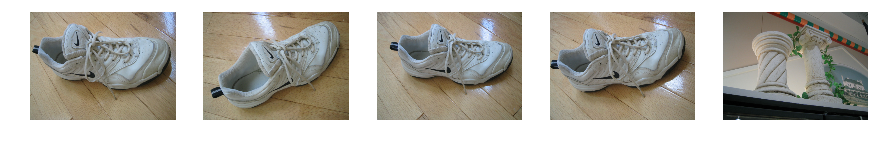

results of homography search


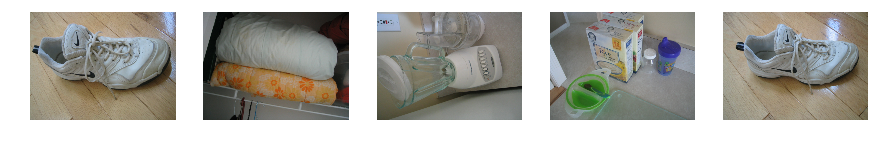

In [11]:
# 検索結果を描画する
# 通常検索の結果
print('results of regular search')
imagesearch.plot_results(src,res_reg[:5])
# ホモグラフィーを用いた検索の結果
print('results of homography search')
imagesearch.plot_results(src,res_geom[:5])